In [1]:
import pickle
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Import modules from the backtester package
from weight_generator import BettingAgainstBetaWeightsGenerator, AlphaWeightGenerator
from backtest_engine import EquityBacktestEngine
from metrics import ExtendedMetrics
import warnings
warnings.filterwarnings("ignore")

# first, run python cache_sp500_data.py to prevent caching all universe every run, then run this script
with open('sp500_data.pkl', 'rb') as f:
    sp500_data = pickle.load(f)

if 'SPY' not in sp500_data:
    sample_ticker = list(sp500_data.keys())[0]
    dates = sp500_data[sample_ticker].index
    start_date = dates.min().strftime('%Y-%m-%d')
    end_date = dates.max().strftime('%Y-%m-%d')
    spy_df = yf.download("SPY", start=start_date, end=end_date, auto_adjust=False)
    # keep only the needed columns to mimic the structure in the cache
    spy_df = spy_df[['Adj Close', 'Volume']].copy()
    sp500_data['SPY'] = spy_df

# exclude SPY since that is our benchmark
stock_tickers = [ticker for ticker in sp500_data.keys() if ticker != 'SPY']
prices_dict = {}
for ticker in stock_tickers:
    df = sp500_data[ticker]
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    prices_dict[ticker] = df['Adj Close']

price_df = pd.DataFrame(prices_dict).dropna(how='all')
price_df = price_df.sort_index()

[*********************100%***********************]  1 of 1 completed


In [2]:
skewness_only = AlphaWeightGenerator(lookback_period=60,  
    rebalance_frequency='ME',  
    skew_formation_window=5,
    skew_weight=1.0  
)

# bab_only = BettingAgainstBetaWeightsGenerator(lookback_period=60, rebalance_frequency='ME')
weights_df = skewness_only.generate_weights(sp500_data) # New
print(f"Generated weights DataFrame with shape: {weights_df.shape}")

Rebalancing weights on 2010-04-30 00:00:00:
  Long: 0.56, Short: 0.44
  Long beta: 0.58, Short beta: -0.58, Net beta: -0.0000
  Strategy mix: BAB 0% / Skew 100%
Rebalancing weights on 2010-06-30 00:00:00:
  Long: 0.48, Short: 0.52
  Long beta: 0.51, Short beta: -0.51, Net beta: -0.0000
  Strategy mix: BAB 0% / Skew 100%
Rebalancing weights on 2010-08-31 00:00:00:
  Long: 0.45, Short: 0.55
  Long beta: 0.49, Short beta: -0.49, Net beta: -0.0000
  Strategy mix: BAB 0% / Skew 100%
Rebalancing weights on 2010-09-30 00:00:00:
  Long: 0.54, Short: 0.46
  Long beta: 0.51, Short beta: -0.51, Net beta: 0.0000
  Strategy mix: BAB 0% / Skew 100%
Rebalancing weights on 2010-11-30 00:00:00:
  Long: 0.42, Short: 0.58
  Long beta: 0.46, Short beta: -0.46, Net beta: 0.0000
  Strategy mix: BAB 0% / Skew 100%
Rebalancing weights on 2010-12-31 00:00:00:
  Long: 0.47, Short: 0.53
  Long beta: 0.54, Short beta: -0.54, Net beta: 0.0000
  Strategy mix: BAB 0% / Skew 100%
Rebalancing weights on 2011-01-31 00:

In [3]:
initial_cash = 100_000
engine = EquityBacktestEngine(initial_cash=initial_cash)
backtest_result = engine.run_backtest(weights_df, price_df)
portfolio_values_series = backtest_result['portfolio_values'] 

portfolio_returns = portfolio_values_series.pct_change().dropna()

spy_prices = sp500_data['SPY']['Adj Close']
spy_prices.index = pd.to_datetime(spy_prices.index)
spy_prices = spy_prices.sort_index()
spy_returns = spy_prices.pct_change().dropna()

Backtest complete. Final Portfolio Value: 131465.46



Performance Metrics:
Cumulative Return (%): 31.465455284623477
Annualized Return (%): 2.027871031234141
Annualized Volatility (%): 4.888612432507801
Sharpe Ratio: 0.3186310081420418
Max Drawdown (%): -7.427739312130289
VaR 5% Daily (%): -0.4434530781202761
CVaR 5% Daily (%): -0.6689358205980799
Average Daily Turnover (%): 3.1987594036023927


<Axes: title={'center': 'Skewness Strategy Portfolio Value'}, xlabel='Date', ylabel='Portfolio Value ($)'>

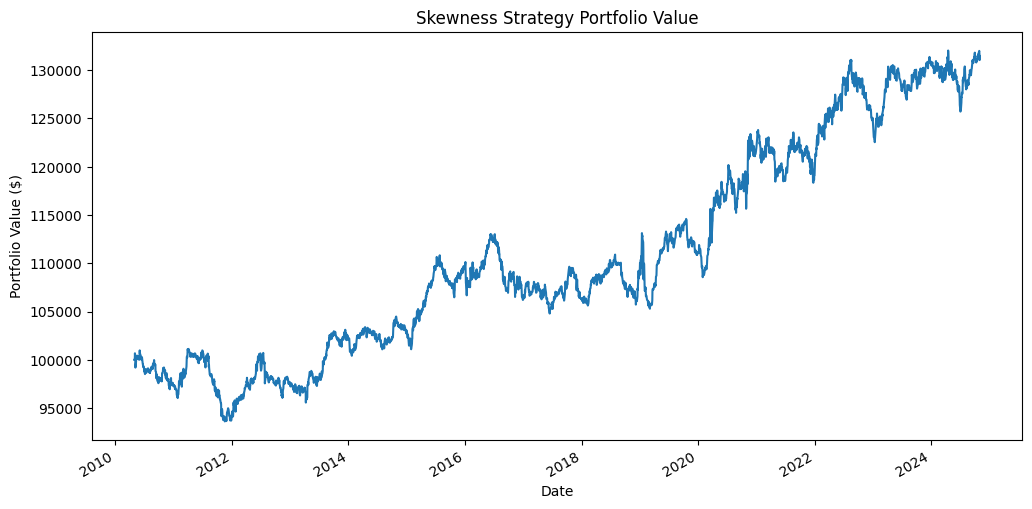

In [5]:
metrics_calculator = ExtendedMetrics()
metrics = metrics_calculator.calculate(portfolio_values_series, 
                                      portfolio_returns,
                                      benchmark_returns=spy_returns,
                                      weights=weights_df)
print("\nPerformance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
# plot returns
spy_portfolio_values = pd.Series(index=spy_prices.index)
spy_initial_value = spy_prices.iloc[0]
spy_scale_factor = initial_cash / spy_initial_value
spy_portfolio_values = spy_prices * spy_scale_factor


plt.figure(figsize=(12, 6))
# replace this with strat name
plt.title('Skewness Strategy Portfolio Value') 
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
portfolio_values_series.plot()

Generating BAB strategy weights...
Rebalancing weights on 2010-04-30 00:00:00:
  Long: 0.83, Short: 0.17
  Long beta: 0.34, Short beta: -0.34, Net beta: 0.0000
Rebalancing weights on 2010-06-30 00:00:00:
  Long: 0.79, Short: 0.21
  Long beta: 0.39, Short beta: -0.39, Net beta: -0.0000
Rebalancing weights on 2010-08-31 00:00:00:
  Long: 0.79, Short: 0.21
  Long beta: 0.38, Short beta: -0.38, Net beta: -0.0000
Rebalancing weights on 2010-09-30 00:00:00:
  Long: 0.81, Short: 0.19
  Long beta: 0.36, Short beta: -0.36, Net beta: 0.0000
Rebalancing weights on 2010-11-30 00:00:00:
  Long: 0.83, Short: 0.17
  Long beta: 0.31, Short beta: -0.31, Net beta: 0.0000
Rebalancing weights on 2010-12-31 00:00:00:
  Long: 0.84, Short: 0.16
  Long beta: 0.27, Short beta: -0.27, Net beta: -0.0000
Rebalancing weights on 2011-01-31 00:00:00:
  Long: 0.86, Short: 0.14
  Long beta: 0.26, Short beta: -0.26, Net beta: 0.0000
Rebalancing weights on 2011-02-28 00:00:00:
  Long: 0.90, Short: 0.10
  Long beta: 0.23

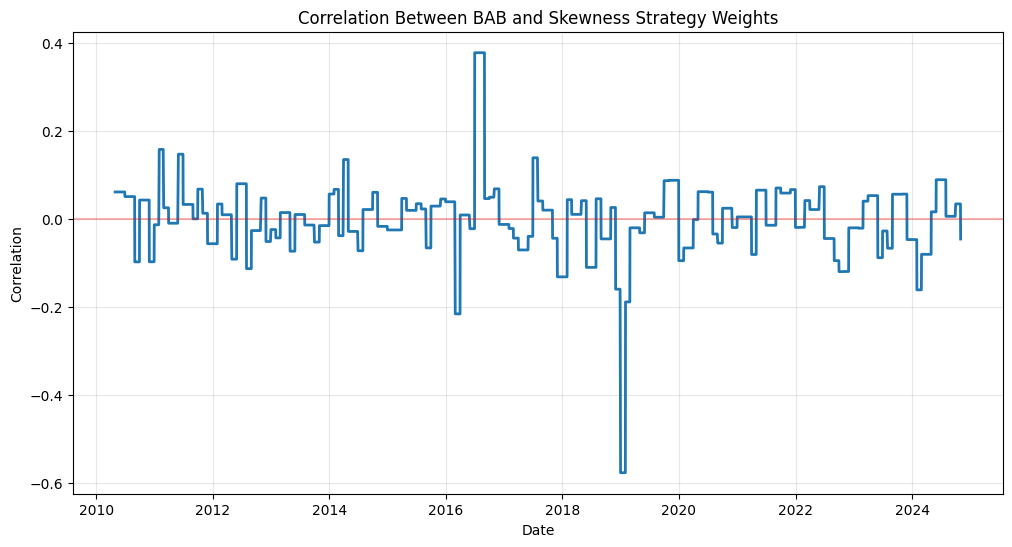

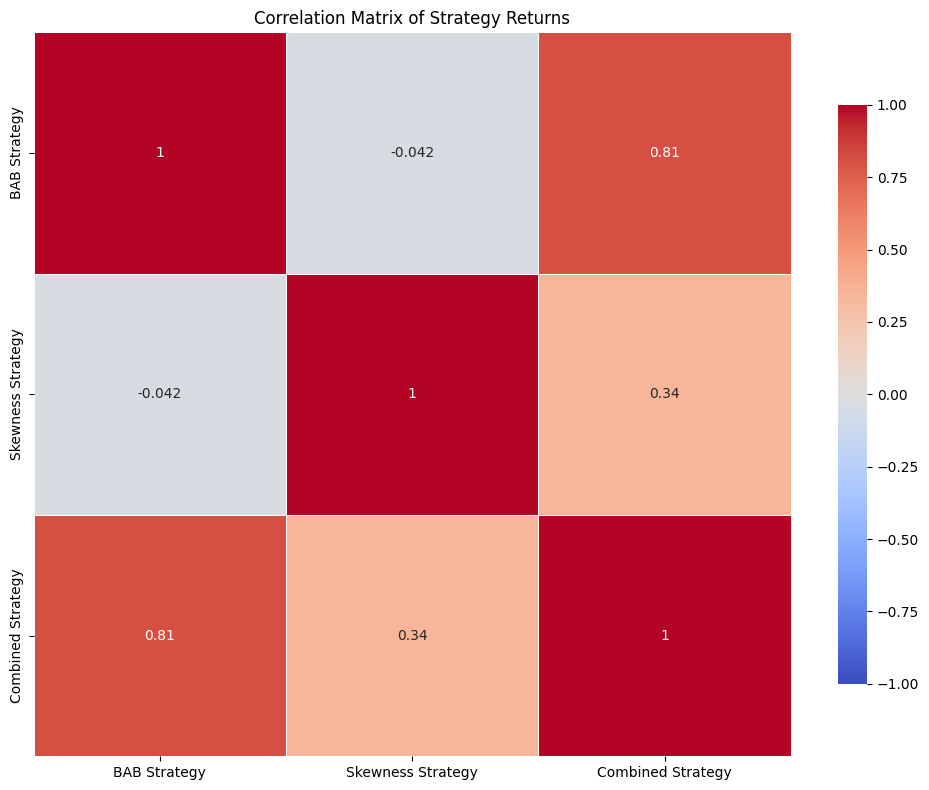

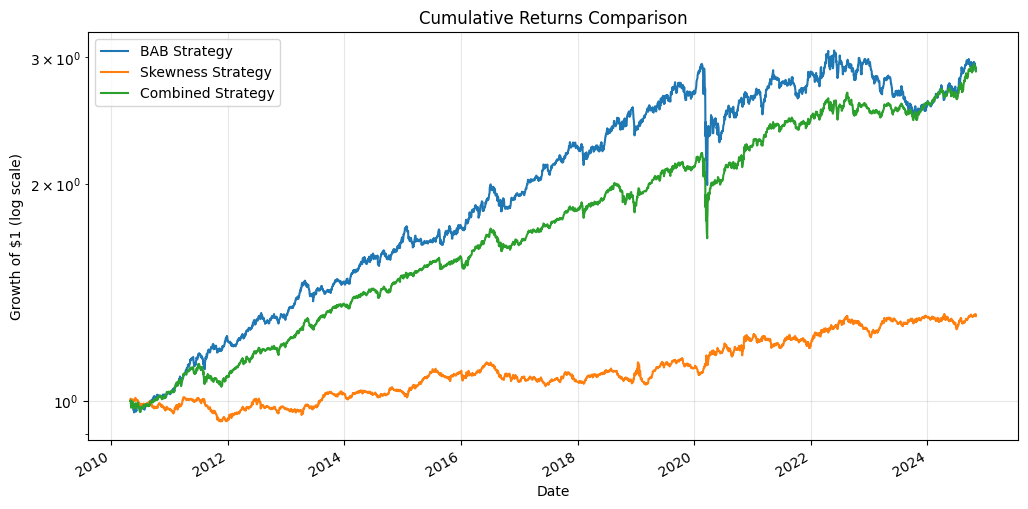

In [ ]:
def plot_strategy_correlations(data, initial_cash=100_000):
    bab_only = BettingAgainstBetaWeightsGenerator(lookback_period=60, rebalance_frequency='ME')
    skew_only = AlphaWeightGenerator(lookback_period=60, rebalance_frequency='ME', 
                                    skew_formation_window=5, skew_weight=1.0)  # 100% skewness
    combined = AlphaWeightGenerator(lookback_period=60, rebalance_frequency='ME', 
                                   skew_formation_window=5, skew_weight=0.5)  # 50/50 mix

    print("Generating BAB strategy weights...")
    bab_weights = bab_only.generate_weights(data)
    
    print("\nGenerating Skewness strategy weights...")
    skew_weights = skew_only.generate_weights(data)
    
    print("\nGenerating Combined strategy weights...")
    combined_weights = combined.generate_weights(data)
    
    stock_tickers = [ticker for ticker in data.keys() if ticker != 'SPY']
    prices_dict = {}
    for ticker in stock_tickers:
        df = data[ticker]
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        prices_dict[ticker] = df['Adj Close']
    
    price_df = pd.DataFrame(prices_dict).dropna(how='all')
    price_df = price_df.sort_index()
    
    # Calculate forward returns (1-month forward returns to match rebalance period)
    forward_returns = price_df.pct_change(periods=21).shift(-21)  
    common_dates = bab_weights.index.intersection(forward_returns.index)
    bab_weights_aligned = bab_weights.loc[common_dates]
    skew_weights_aligned = skew_weights.loc[common_dates]
    combined_weights_aligned = combined_weights.loc[common_dates]
    forward_returns_aligned = forward_returns.loc[common_dates]
    
    engine = EquityBacktestEngine(initial_cash=initial_cash)
    bab_result = engine.run_backtest(bab_weights, price_df)
    skew_result = engine.run_backtest(skew_weights, price_df)
    combined_result = engine.run_backtest(combined_weights, price_df)
    
    bab_returns = bab_result['portfolio_values'].pct_change().dropna()
    skew_returns = skew_result['portfolio_values'].pct_change().dropna()
    combined_returns = combined_result['portfolio_values'].pct_change().dropna()
    
    weight_corr_dates = bab_weights_aligned.index.intersection(skew_weights_aligned.index)
    if len(weight_corr_dates) > 0:
        weight_corrs = []
        for date in weight_corr_dates:
            bab_w = bab_weights_aligned.loc[date].dropna()
            skew_w = skew_weights_aligned.loc[date].dropna()
            
            common_tickers = bab_w.index.intersection(skew_w.index)
            if len(common_tickers) > 10:  
                corr = np.corrcoef(bab_w[common_tickers], skew_w[common_tickers])[0, 1]
                weight_corrs.append((date, corr))
        
        if weight_corrs:
            corr_df = pd.DataFrame(weight_corrs, columns=['Date', 'Correlation'])
            corr_df.set_index('Date', inplace=True)
            
            plt.figure(figsize=(12, 6))
            plt.plot(corr_df.index, corr_df['Correlation'], linewidth=2)
            plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
            plt.title('Correlation Between BAB and Skewness Strategy Weights')
            plt.xlabel('Date')
            plt.ylabel('Correlation')
            plt.grid(True, alpha=0.3)
            plt.show()
    returns_data = {
        'BAB Strategy': bab_returns,
        'Skewness Strategy': skew_returns, 
        'Combined Strategy': combined_returns
    }
    returns_df = pd.DataFrame(returns_data).dropna()
    
    if len(returns_df) > 0:
        corr_matrix = returns_df.corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                   linewidths=0.5, cbar_kws={"shrink": 0.8})
        plt.title('Correlation Matrix of Strategy Returns')
        plt.tight_layout()
        plt.show()
        
        (1 + returns_df).cumprod().plot(figsize=(12, 6))
        plt.title('Cumulative Returns Comparison')
        plt.xlabel('Date')
        plt.ylabel('Growth of $1 (log scale)')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()


import seaborn as sns
plot_strategy_correlations(sp500_data, initial_cash=100_000)